## Training HiCPlus on full window

In [6]:
import sys
import numpy as np
#import matplotlib.pyplot as plt
import pickle
import os
import gzip
import torch.nn.functional as F
from torch.utils import data
import torch
import torch.optim as optim
from torch.autograd import Variable
from time import gmtime, strftime
import sys
import torch.nn as nn
import argparse
import Data.GM12878_DataModule as gm12878


dm = gm12878.GM12878Module(batch_size=1,
                       res=10000,
                       piece_size=269)

dm.prepare_data()
dm.setup('fit')

train_loader = dm.train_dataloader()
valid_loader = dm.val_dataloader()
use_gpu = 1

conv2d1_filters_numbers = 8
conv2d1_filters_size = 9
conv2d2_filters_numbers = 8
conv2d2_filters_size = 1
conv2d3_filters_numbers = 1
conv2d3_filters_size = 5


num_epochs = 50

class hicplus(nn.Module):
    def __init__(self, D_in, D_out):
        super(hicplus, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, conv2d1_filters_numbers, conv2d1_filters_size)
        self.conv2 = nn.Conv2d(conv2d1_filters_numbers, conv2d2_filters_numbers, conv2d2_filters_size)
        self.conv3 = nn.Conv2d(conv2d2_filters_numbers, 1, conv2d3_filters_size)

    def forward(self, x):
        #print("start forwardingf")
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        return x

Net = hicplus(269, 257)
Net = Net.cuda()
optimizer = optim.SGD(Net.parameters(), lr=0.0001)
_loss     = nn.MSELoss()

best_loss = 1000000

for epoch in range(num_epochs):
    print("epoch:"+str(epoch))
    for i, batch in enumerate(train_loader):
        Net.train()
        #print(str(i)+"/"+str(train_loader.dataset.data.shape[0]))
        data, target, _ = batch
        data   = data.to("cuda")
        target = target.to("cuda")[:,:,6:-6,6:-6] 
        optimizer.zero_grad()
        pred            =  Net(data)
        loss            = _loss(pred, target)
        loss.backward()
        optimizer.step()
        
    tot_val_loss = 0
    for i, batch in enumerate(valid_loader):
        Net.eval()
        data, target, _= batch
        data         = data.to("cuda")
        target       = target.to("cuda")[:,:,6:-6,6:-6]
        optimizer.zero_grad()
        pred         = Net(data)
        val_los      = _loss(pred, target)
        tot_val_loss  +=val_los.item()
    if tot_val_loss < best_loss:
        best_loss = tot_val_loss
        print(tot_val_loss)
        torch.save(Net.state_dict(), "Expanded_Window_Models/big_269_hicplus.pytorch")



Preparing the Preparations ...
Ready to go
epoch:0
32.69393505901098
epoch:1
13.608283107634634
epoch:2
8.631063850130886
epoch:3
7.688058033818379
epoch:4
7.496070122346282
epoch:5
7.433472275501117
epoch:6
7.3971549472771585
epoch:7
7.368245031451806
epoch:8
7.34236043994315
epoch:9
7.318210180383176
epoch:10
7.295314721530303
epoch:11
7.273476430447772
epoch:12
7.252565660746768
epoch:13
7.232522686943412
epoch:14
7.213284769793972
epoch:15
7.194809949491173
epoch:16
7.17703956970945
epoch:17
7.159929642220959
epoch:18
7.143461225321516
epoch:19
7.127589842304587
epoch:20
7.112286649178714
epoch:21
7.097523764241487
epoch:22
7.083271973533556
epoch:23
7.069518863456324
epoch:24
7.056230450980365
epoch:25
7.043389028171077
epoch:26
7.030968662817031
epoch:27
7.0189552719239146
epoch:28
7.007327237166464
epoch:29
6.996071505360305
epoch:30
6.985173575114459
epoch:31
6.974616514286026
epoch:32
6.964390835026279
epoch:33
6.954475137172267
epoch:34
6.944859576411545
epoch:35
6.9355315552

## Training hicsr on full window

In [1]:
#pulled from https://github.com/PSI-Lab/HiCSR
#import directories were adjusted and dataset was set to ours.

import pdb
import abc
import argparse
import os
import logging.config
import yaml
import json
import pickle
import numpy as np

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from other_tools.HiCSR.models.HiCSR_model import Generator, Discriminator
from other_tools.HiCSR.models.DAE_model import DAE
from other_tools.HiCSR.feature_reconstruction_loss import FeatureReconstructionLoss
from Data.GM12878_DataModule import GM12878Module 
import matplotlib
import matplotlib.pyplot as plt

#def setup_logging(log_dir, default_path='logging.yaml', default_level=logging.INFO, env_key='LOG_CFG'):
#    '''
#    Setup logging configuration, config file is logging.yaml
#    '''
#    path = default_path
#    value = os.getenv(env_key, None)
#    if value:
#        path = value
#    if os.path.exists(path):
#        with open(path, 'rt') as f:
#            config = yaml.safe_load(f.read())
#        config['handlers']['debug_file_handler']['filename'] = log_dir
#        logging.config.dictConfig(config)
#    else:
#        logging.basicConfig(level=default_level)


        
class ClassModel(object):
    __metaclass__ = abc.ABCMeta

    _hparams = {}
    _model = None
    _input_shape = None
    _output_shape = None
    _writer = None

    def set_data_shapes(self, input_shape, output_shape):
        self._input_shape = input_shape
        self._output_shape = output_shape

    def set_writer(self, summary_writer):
        self._writer = summary_writer

    @abc.abstractmethod
    def set_model(self, hparams):
        pass

    @abc.abstractmethod
    def fit_model(self, train_loader, val_loader):
        pass

    @abc.abstractmethod
    def _set_default_model_specific_hparams(self):
        pass

    def set_hparams(self, hparams_args={}):
        hparams = {
                "random_state" : None,
                }
        self._hparams = hparams
        self._set_default_model_specific_hparams()
        self._hparams.update(hparams_args)
        self._hparams.update(hparams)
    def update_hparams(self, hparams_args):
        self._hparams.update(hparams_args)

    def save_model(self):
        model_name = self.__class__.__name__
        logging.info("saving model as {}.pkl...".format(model_name))
        self._writer = None
        torch.save(self._model.state_dict(),
                   './experiments/{}/{}.pth'.format(self._hparams['experiment'],
                       self._hparams['experiment']))

        with open('./experiments/{}/{}.pkl'.format(self._hparams['experiment'],model_name), 'wb') as output:
            pickle.dump(self.__dict__, output, protocol=pickle.HIGHEST_PROTOCOL)
        logging.info("save complete")

    def load_model(self, filename):
        logging.info("loading model...")
        with open(filename+'.pkl', 'rb') as model_file:
            self.__dict__.clear()
            self.__dict__.update(pickle.load(model_file))
            self._model = torch.load(filename+'.pth')
        logging.info("model loaded")

        
        
class HiCSRModel(ClassModel):

    def _set_default_model_specific_hparams(self):
            self._hparams.update({
                "lambda_a": 2.5e-3,
                "lambda_f": 1,
                "lambda_1": 1,
                "G_optimizer": 'adam',
                "G_learning_rate": 1e-5,
                "D_optimizer": 'adam',
                "D_learning_rate": 1e-5,
                "beta_1": 0.9,
                "beta_2": 0.999,
                "res_blocks": 15,
                "epochs": 50,
                "num_workers":8,
                "batch_size":128,
                "random_state": 12345,
                })

    def set_model(self):
        device = torch.device("cuda:{}".format(self._hparams['gpu']) if torch.cuda.is_available() else "cpu")
        logging.info('setting model on device: {}'.format(device))

        if torch.cuda.device_count() > 1:
            logging.info('Using {} devices'.format(torch.cuda.device_count()))
            G = Generator(num_res_blocks=self._hparams['res_blocks'])
            D = Discriminator()
            G.init_params()
            D.init_params()
            #MAX
            #params = torch.load("experiments/test_HiCSR/checkpoints/HiCSRModel_ckpt_80.pth")
            #G.load_state_dict(params['G_state_dict'])
            #D.load_state_dict(params['D_state_dict'])
            #MAX
            G = nn.DataParallel(G).cuda()
            D = nn.DataParallel(D).cuda()
        else:
            G = Generator(num_res_blocks=self._hparams['res_blocks']).to(device)
            D = Discriminator().to(device)
            #pdb.set_trace()
            #params = torch.load("experiments/test_HiCSR/checkpoints/HiCSRModel_ckpt_80.pth")
            #G.load_state_dict(params['G_state_dict'])
            #D.load_state_dict(params['D_state_dict'])
            G.init_params()
            D.init_params()

        self._model = G
        self.D = D

    def fit_model(self, train_loader, valid_loader):
        device = torch.device("cuda:{}".format(self._hparams['gpu']) if torch.cuda.is_available() else "cpu")
        logging.info('fitting model on device: {}'.format(device))

        #train_loader = DataLoader(dataset=train_set,
        #                          num_workers=self._hparams['num_workers'],
        #                          batch_size=self._hparams['batch_size'],
        #                          shuffle=True)

        #valid_loader = DataLoader(dataset=valid_set,
        #                          num_workers=self._hparams['num_workers'],
        #                          batch_size=self._hparams['batch_size'],
        #                          shuffle=False)
        G_optimizer = Adam(self._model.parameters(),lr=self._hparams['G_learning_rate'])

        D_optimizer = Adam(self.D.parameters(),lr=self._hparams['D_learning_rate'])

        adv_loss = nn.BCEWithLogitsLoss().to(device)
        l1_loss = nn.L1Loss().to(device)
        feature_reconstruction_loss = FeatureReconstructionLoss().to(device)


        logging.info("beginning adversarial training")
        for epoch in range(0, self._hparams['epochs']):
            print(epoch)
            train_G_total_epoch_loss = 0
            train_G_adv_epoch_loss = 0
            train_G_image_epoch_loss = 0
            train_G_feature_epoch_loss = 0

            D_epoch_loss = 0
            D_real_epoch_loss = 0
            D_fake_epoch_loss = 0
            D_real_epoch_acc = 0
            D_fake_epoch_acc = 0

            self._model.train()
            self.D.train()

            for iteration, (data, target, _) in enumerate(train_loader):

                #######################
                #       Train G       #
                #######################

                self._model.zero_grad()
                target, data = target.float().to(device), data.float().to(device)
                target        = target[:,:,6:-6,6:-6]
                # I_sr = G(lr)
                output = self._model(data)

                # compute pixelwise loss
                image_loss = l1_loss(output, target)

                # compute feature reconstruction loss
                feature_loss = sum(feature_reconstruction_loss(output, target))

                # compute adversarial loss
                pred_fake = self.D(output)
                labels_real = torch.ones_like(pred_fake, requires_grad=False).to(device)
                GAN_loss = adv_loss(pred_fake, labels_real)

                # compute total generator loss
                total_loss_G = self._hparams['lambda_a'] * GAN_loss + \
                               self._hparams['lambda_1'] * image_loss + \
                               self._hparams['lambda_f'] * feature_loss

                # gradient step for generator
                total_loss_G.backward()
                G_optimizer.step()

                # record losses
                train_G_total_epoch_loss   += total_loss_G.item()
                train_G_adv_epoch_loss     += GAN_loss.item()
                train_G_image_epoch_loss   += image_loss.item()
                train_G_feature_epoch_loss += feature_loss

                #######################
                #       Train D       #
                #######################

                self.D.zero_grad()

                # train on real data
                pred_real = self.D(target)
                labels_real = torch.ones_like(pred_real, requires_grad=False).to(device)
                pred_labels_real = (pred_real>0.5).float().detach()
                acc_real = (pred_labels_real == labels_real).float().sum()/labels_real.shape[0]
                loss_real = adv_loss(pred_real, labels_real)
                loss_real.backward()

                # train on fake data
                output = self._model(data)
                pred_fake = self.D(output.detach())
                labels_fake = torch.zeros_like(pred_fake, requires_grad=False).to(device)
                pred_labels_fake = (pred_fake>0.5).float().detach()
                acc_fake = (pred_labels_fake == labels_fake).float().sum()/labels_fake.shape[0]
                loss_fake = adv_loss(pred_fake, labels_fake)
                loss_fake.backward()

                # get total loss
                total_loss_D = loss_real + loss_fake

                # gradient step for discriminator
                D_optimizer.step()

                # record losses
                D_epoch_loss += total_loss_D.item()
                D_real_epoch_loss += loss_real.item()
                D_fake_epoch_loss += loss_fake.item()
                D_real_epoch_acc += acc_real.item()
                D_fake_epoch_acc += acc_fake.item()

                # log training progress
                if iteration%1 == 0:
                    logging.info("===> Training Epoch[{}]({}/{}) "
                                 "[G: {:.4f} l1 loss: {:.4f} adv loss: {:.4f} feat loss: {:.4f}] "
                                 "[D: {:.4f} real_loss: {:.4f} real_acc: {:.4f} "
                                 "fake_loss: {:.4f} fake_acc: {:.4f}]".format(epoch,
                                                                              iteration,
                                                                              len(train_loader),
                                                                              total_loss_G.item(),
                                                                              image_loss.item(),
                                                                              GAN_loss.item(),
                                                                              feature_loss,
                                                                              total_loss_D.item(),
                                                                              loss_real.item(),
                                                                              acc_real.item(),
                                                                              loss_fake.item(),
                                                                              acc_fake.item()))
            with torch.no_grad():
                valid_epoch_image_loss = 0
                self._model.eval()
                for i, (data,target, _) in enumerate(valid_loader):
                    target, data = target.float().to(device), data.float().to(device)
                    target        = target[:,:,6:-6,6:-6]
                    output        = self._model(data).detach()
                    image_loss = l1_loss(target, output)
                    valid_epoch_image_loss += image_loss.item()

            valid_image_loss = valid_epoch_image_loss/len(valid_loader)
            D_real_loss = D_real_epoch_loss/len(train_loader)
            D_real_acc = D_real_epoch_acc/len(train_loader)
            D_fake_loss = D_fake_epoch_loss/len(train_loader)
            D_fake_acc = D_fake_epoch_acc/len(train_loader)
            D_loss = D_epoch_loss/len(train_loader)
            train_G_total_loss = train_G_total_epoch_loss/len(train_loader)
            train_G_image_loss = train_G_image_epoch_loss/len(train_loader)
            train_G_adv_loss = train_G_adv_epoch_loss/len(train_loader)
            train_G_feature_loss = train_G_feature_epoch_loss/len(train_loader)


            self._log_epoch_losses(self._writer,
                                   epoch,
                                   D_loss,
                                   D_real_loss,
                                   D_real_acc,
                                   D_fake_loss,
                                   D_fake_acc,
                                   train_G_total_loss,
                                   train_G_image_loss,
                                   train_G_adv_loss,
                                   train_G_feature_loss,
                                   valid_image_loss)
            #self._log_epoch_images(self._writer, epoch, data, target, output, 2)

            if epoch%1 == 0:
                self._save_checkpoint(epoch, G_optimizer, D_optimizer)

                
    def _log_epoch_losses(self,
                          summary_writer,
                          epoch,
                          D_loss,
                          D_loss_real,
                          D_acc_real,
                          D_loss_fake,
                          D_acc_fake,
                          train_G_total_loss,
                          train_G_image_loss,
                          train_G_adv_loss,
                          train_G_feature_loss,
                          valid_image_loss):
        summary_writer.add_scalar('D_loss', D_loss, epoch)
        summary_writer.add_scalars('D_loss_components', {'real': D_loss_real, 'fake':D_loss_fake}, epoch)
        summary_writer.add_scalars('D_acc_components', {'real': D_acc_real, 'fake':D_acc_fake}, epoch)
        summary_writer.add_scalars('G_loss', {'train': train_G_total_loss, 'valid': valid_image_loss}, epoch)
        summary_writer.add_scalar('image_loss', train_G_image_loss, epoch)
        summary_writer.add_scalar('adversarial_loss', train_G_adv_loss, epoch)
        summary_writer.add_scalar('feature_loss', train_G_feature_loss, epoch)
        summary_writer.flush()

        logging.info("Epoch {} Complete: \n[D Loss: {:.4f} Real D Loss: {:.4f} Fake D_loss: {:.4f}] [Train G Loss: {:.4f} Valid G loss: {:.4f}]\n".format(epoch,

                             D_loss, D_loss_real, D_loss_fake,

                             train_G_total_loss, valid_image_loss))

    def _log_epoch_images(self, summary_writer, epoch, data, target, output, n_images):
        data = data.cpu().detach().numpy()
        target = target.cpu().detach().numpy()
        output = output.cpu().detach().numpy()

        for i in range(0,n_images):
            fig, axs = plt.subplots(1,3, facecolor='w', edgecolor='k')
            fig.subplots_adjust(hspace = .5, wspace=.1)
            axs = axs.ravel()
            for j, mat in enumerate([data[i],target[i],output[i]]):
                if mat.shape[-1] == 40:
                    mat = mat[:,6:34,6:34]
                im = axs[j].matshow(mat[0], cmap='YlOrRd', interpolation="none", vmin=-1, vmax=1)
                plt.setp(axs[j].get_xticklabels(), visible=False)
                plt.setp(axs[j].get_yticklabels(), visible=False)
                axs[j].tick_params(axis='both', which='both', length=0)
            plt.title('input/target/prediction')
            summary_writer.add_figure('epoch_image_comparison_{}'.format(i),fig,epoch)
            summary_writer.flush()

    def _save_checkpoint(self, epoch, G_optimizer, D_optimizer, scheduler = None):
        state = {
                'epoch': epoch,
                'G_state_dict': self._model.state_dict(),
                'D_state_dict': self.D.state_dict(),
                'G_optimizer': G_optimizer.state_dict(),
                'D_optimizer': D_optimizer.state_dict(),
                'scheduler': scheduler,
                }
        torch.save(state, './experiments/{}/checkpoints/{}_ckpt_{}.pth'.format(self._hparams['experiment'], self.__class__.__name__, epoch))
        
        
class DAEModel(ClassModel):
    def _set_default_model_specific_hparams(self):
            self._hparams.update({
                "batch_size": 256,
                "epochs": 50,
                "learning_rate": 0.0001,
                "noise_scale": 0.1,
                "gpu": 0,
                "num_workers": 8,
                "random_state": 12345,
                })

    def set_model(self):
        torch.manual_seed(self._hparams['random_state'])
        device = torch.device("cuda:{}".format(self._hparams['gpu']) if torch.cuda.is_available() else "cpu")
        logging.info('setting model on device: {}'.format(device))

        if torch.cuda.device_count() > 1:
            logging.info('Using {} devices'.format(torch.cuda.device_count()))
            net = nn.DataParallel(DAE().to(device))
        else:
            net = DAE().to(device)

        net = DAE().to(device)
        self._model = net

    def fit_model(self, train_loader, valid_loader):
        device = torch.device("cuda:{}".format(self._hparams['gpu']) if torch.cuda.is_available() else "cpu")
        logging.info('fitting model on device: {}'.format(device))

        '''
        train_loader = DataLoader(dataset=train_set,
                                  num_workers=self._hparams['num_workers'],
                                  batch_size=self._hparams['batch_size'],
                                  shuffle=True)

        valid_loader = DataLoader(dataset=valid_set,
                                  num_workers=self._hparams['num_workers'],
                                  batch_size=self._hparams['batch_size'],
                                  shuffle=False)
        '''

        optimizer = Adam(self._model.parameters(), lr=self._hparams['learning_rate'])

        criterion = nn.MSELoss()
        for epoch in range(0, self._hparams['epochs']):
            train_epoch_loss = 0
            for iteration, (data, target, _) in enumerate(train_loader):
                self._model.train()
                self._model.zero_grad()
                target = target.float().to(device)
                data   = data.float().to(device)
                #target = target[:,:,0:40,0:40]
                target_noisy = target + self._hparams['noise_scale'] * torch.randn_like(target)
                target_noisy = torch.clamp(target_noisy, min=-1, max=1)
                output = self._model(target_noisy)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                train_epoch_loss += loss.item()

                if iteration%1 == 0:
                    logging.info("===> Training Epoch[{}]({}/{}): Loss: {:.8f}".format(epoch, iteration, len(train_loader), loss.item()))

            valid_epoch_loss = 0
            with torch.no_grad():
                for iteration, (data, target,  _) in enumerate(valid_loader):
                    self._model.eval()
                    target = target.float().to(device)
                    target_noisy = target + self._hparams['noise_scale'] * torch.randn_like(target)
                    target_noisy = torch.clamp(target_noisy, min=-1, max=1)
                    output = self._model(target)
                    loss = criterion(output, target)
                    valid_epoch_loss += loss.item()

            train_epoch_loss = train_epoch_loss/len(train_loader)
            valid_epoch_loss = valid_epoch_loss/len(valid_loader)
            self._log_epoch_losses(self._writer, epoch, train_epoch_loss, valid_epoch_loss)

            target = target.cpu().detach().numpy()
            target_noisy = target_noisy.cpu().detach().numpy()
            output = output.cpu().detach().numpy()
            #self._log_epoch_images(self._writer, epoch, target_noisy, target, output, 2)


            if epoch%1 == 0:
                torch.save(self._model,'./experiments/{}/checkpoints/{}_ckpt_{}.pth'.format(self._hparams['experiment'], self.__class__.__name__, epoch))

    def _log_epoch_losses(self, summary_writer, epoch, train_loss, valid_loss):
        summary_writer.add_scalars('mse', {'validation loss':valid_loss, 'training loss':train_loss}, epoch)
        summary_writer.flush()

        logging.info("Epoch {} Complete: Avg. Train Loss: {:.8f} - Avg. Valid Loss: {:.8f}\n".format(epoch, train_loss, valid_loss))

    def _log_epoch_images(self, summary_writer, epoch, target_noisy, target, output, n_images):
        if epoch%5 == 0:
            for i in range(0,n_images):
                fig, axs = plt.subplots(1,3, facecolor='w', edgecolor='k')
                fig.subplots_adjust(hspace = .5, wspace=.1)
                axs = axs.ravel()
                for j, mat in enumerate([target_noisy[i],target[i],output[i]]):
                    if mat.shape[-1] == 40:
                        mat = mat[:,6:34,6:34]
                    axs[j].matshow(mat[0], cmap='YlOrRd', interpolation="none", vmin=-1, vmax=1)
                    plt.setp(axs[j].get_xticklabels(), visible=False)
                    plt.setp(axs[j].get_yticklabels(), visible=False)
                    axs[j].tick_params(axis='both', which='both', length=0)
                plt.title('noisy_input/target/prediction')
                summary_writer.add_figure('epoch_image_comparison_{}'.format(i),fig,epoch)
                summary_writer.flush()

MODEL_REGISTRY = {
            "HiCSR":HiCSRModel,
            "DAE":DAEModel,
            }


def main():
    model_parser = argparse.ArgumentParser()
    model_parser.add_argument('--data_fp', type=str, required=True,
                                help="directory containing training and validation data to use for model training",
                             default="irrelevant")
    model_parser.add_argument('--model', type=str, required=True,
            help="Set the model to be trained, There are two options: 'HiCSR' will train the Hi-C enhancement model and 'DAE' will train the Denoising Autoencoder on the high resolution data",
                              default="HiCSR")
    model_parser.add_argument('--gpu', type=int, default=0,
                                help="GPU number to use for training, if the system has no GPU, training will automatically default to using the CPU. default = 0.")
    model_parser.add_argument('--experiment', type=str, required=True,
                                help="experiment name associated with the training run, all model logging and final model file are saved under this name. Experiment name must match an entry in the experiment_hyperparameters.json config file",
                             default="HiCSR_Big_269")
    args = model_parser.parse_args(['--data_fp',
                                    'irrelevant',
                                    '--model',
                                    'HiCSR',
                                    '--experiment',
                                    'HiCSR_Big_269'])
    
    json_stri="""
{
    "HiCSR_Big_269":
    {   "lambda_a": 2.5e-3,
        "lambda_f": 1,
        "lambda_1": 1,
        "G_optimizer": "adam",
        "G_learning_rate": 1e-5,
        "D_optimizer": "adam",
        "D_learning_rate": 1e-5,
        "beta_1": 0.9,
        "beta_2": 0.99,
        "epochs": 50,
        "batch_size": 2,
        "res_blocks": 15
    }
}
"""
    
    #with open('other_tools/HiCSR/experiment_hyperparameters.json', 'r') as f:
    #    experiment_queue = json.load(f)
    #    assert args.experiment in experiment_queue
    experiment_queue = json.loads(json_stri)

    experiment_specific_hparams = experiment_queue[args.experiment]

    if not os.path.exists('./experiments'):
        os.mkdir('./experiments')
        

    experiment_fp = './experiments/{}'.format(args.experiment)
    if not os.path.exists(experiment_fp):
        os.mkdir(experiment_fp)
        os.mkdir(experiment_fp+'/logs/')
        os.mkdir(experiment_fp+'/checkpoints/')
        os.mkdir(experiment_fp+'/tensorboard/')

    #setup_logging(log_dir='./experiments/{}/logs/{}.log'.format(args.experiment, args.experiment))
    writer = SummaryWriter(log_dir='./experiments/{}/tensorboard/'.format(args.experiment),comment=args.experiment)

   # train_set = DatasetFromFolder(args.data_fp, data_type='train')
   # valid_set = DatasetFromFolder(args.data_fp, data_type='valid')

    dm = GM12878Module(batch_size=1, res=10000, piece_size=269)
    dm.setup(stage='fit')
    train_loader = dm.train_dataloader()
    valid_loader = dm.val_dataloader()
    train_set    = train_loader.dataset
    valid_set    = valid_loader.dataset

    model = MODEL_REGISTRY[args.model]()
    logging.info("defining model: {}".format(model.__class__.__name__))
    model.set_hparams(vars(args))
    model.update_hparams(experiment_specific_hparams)
    logging.info("setting tensorboard writer")
    model.set_writer(writer)
    logging.info("hyperparameters: {}".format(model._hparams))
    hr_shape = train_set.target.shape
    lr_shape = train_set.data.shape
    logging.info("train/valid samples: {}/{}".format(len(train_set), len(valid_set)))
    logging.info("input/output shape: {}/{}".format(lr_shape, hr_shape))
    model.set_data_shapes(input_shape=lr_shape, output_shape=hr_shape)
    model.set_model()
    model.fit_model(train_loader, valid_loader)
    model.save_model()

main()



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


## Training deephic on full window

In [11]:
import Data.GM12878_DataModule as gm12878

import os
import time
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from other_tools.DeepHiC.models.deephic import Generator, Discriminator
from other_tools.DeepHiC.models.loss import GeneratorLoss
from other_tools.DeepHiC.models.ssim import ssim
from math import log10

from other_tools.DeepHiC.all_parser import root_dir

out_dir = "Expanded_Window_Models"
num_epochs = 50

upscale = 1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

dm = gm12878.GM12878Module(batch_size=1)
dm.prepare_data()
dm.setup('fit')
train_loader = dm.train_dataloader()
valid_loader = dm.val_dataloader()

# load network
netG = Generator(upscale, in_channel=1, resblock_num=5).to(device)
netD = Discriminator(in_channel=1).to(device)

# loss function
criterionG = GeneratorLoss().to(device)
criterionD = torch.nn.BCELoss().to(device)

# optimizer
optimizerG = optim.Adam(netG.parameters(), lr=0.0001)
optimizerD = optim.Adam(netD.parameters(), lr=0.0001)

best_ssim = 0
for epoch in range(1, num_epochs+1):
    run_result = {'nsamples': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}

    netG.train()
    netD.train()
    train_bar = tqdm(train_loader)
    for data, target, _ in train_bar:
        batch_size = data.size(0)
        run_result['nsamples'] += batch_size
        ############################
        # (1) Update D network: maximize D(x)-1-D(G(z))
        ###########################
        real_img = target.to(device)
        z = data.to(device)
        fake_img = netG(z)

        ######### Train discriminator #########
        netD.zero_grad()
        real_out = netD(real_img)
        fake_out = netD(fake_img)
        d_loss_real = criterionD(real_out, torch.ones_like(real_out))
        d_loss_fake = criterionD(fake_out, torch.zeros_like(fake_out))
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward(retain_graph=True)
        optimizerD.step()

        ######### Train generator #########
        netG.zero_grad()
        g_loss = criterionG(fake_out.mean(), fake_img, real_img)
        g_loss.backward()
        optimizerG.step()

        run_result['g_loss'] += g_loss.item() * batch_size
        run_result['d_loss'] += d_loss.item() * batch_size
        run_result['d_score'] += real_out.mean().item() * batch_size
        run_result['g_score'] += fake_out.mean().item() * batch_size
        train_bar.set_description(desc=f"[{epoch}/{num_epochs}] Loss_D: {run_result['d_loss']/run_result['nsamples']:.4f} Loss_G: {run_result['g_loss']/run_result['nsamples']:.4f} D(x): {run_result['d_score']/run_result['nsamples']:.4f} D(G(z)): {run_result['g_score']/run_result['nsamples']:.4f}")
    train_gloss = run_result['g_loss']/run_result['nsamples']
    train_dloss = run_result['d_loss']/run_result['nsamples']
    train_dscore = run_result['d_score']/run_result['nsamples']
    train_gscore = run_result['g_score']/run_result['nsamples']

    valid_result = {'g_loss': 0, 'd_loss': 0, 'g_score': 0, 'd_score': 0,
                    'mse': 0, 'ssims': 0, 'psnr': 0, 'ssim': 0, 'nsamples': 0}
    netG.eval()
    netD.eval()
    valid_bar = tqdm(valid_loader)
    with torch.no_grad():
        for val_lr, val_hr, inds in valid_bar:
            batch_size = val_lr.size(0)
            valid_result['nsamples'] += batch_size
            lr = val_lr.to(device)
            hr = val_hr.to(device)
            sr = netG(lr)

            sr_out = netD(sr)
            hr_out = netD(hr)
            d_loss_real = criterionD(hr_out, torch.ones_like(hr_out))
            d_loss_fake = criterionD(sr_out, torch.zeros_like(sr_out))
            d_loss = d_loss_real + d_loss_fake
            g_loss = criterionG(sr_out.mean(), sr, hr)

            valid_result['g_loss'] += g_loss.item() * batch_size
            valid_result['d_loss'] += d_loss.item() * batch_size
            valid_result['g_score'] += sr_out.mean().item() * batch_size
            valid_result['d_score'] += hr_out.mean().item() * batch_size

            batch_mse = ((sr - hr) ** 2).mean()
            valid_result['mse'] += batch_mse * batch_size
            batch_ssim = ssim(sr, hr)
            valid_result['ssims'] += batch_ssim * batch_size
            valid_result['psnr'] = 10 * log10(1/(valid_result['mse']/valid_result['nsamples']))
            valid_result['ssim'] = valid_result['ssims'] / valid_result['nsamples']
            valid_bar.set_description(desc=f"[Predicting in Test set] PSNR: {valid_result['psnr']:.4f} dB SSIM: {valid_result['ssim']:.4f}")

    valid_gloss = valid_result['g_loss'] / valid_result['nsamples']
    valid_dloss = valid_result['d_loss'] / valid_result['nsamples']
    valid_gscore = valid_result['g_score'] / valid_result['nsamples']
    valid_dscore = valid_result['d_score'] / valid_result['nsamples']
    now_ssim = valid_result['ssim'].item()

    if now_ssim > best_ssim:
        best_ssim = now_ssim
        print(f'Now, Best ssim is {best_ssim:.6f}')
        best_ckpt_file = 'big_269_deephic.pytorch'
        torch.save(netG.state_dict(), "Expanded_Window_Models/"+best_ckpt_file)
final_ckpt_g = 'big_269_generator_deephic.pytorch'
final_ckpt_d = 'big_269_discriminator_deephic.pytorch'

torch.save(netG.state_dict(), os.path.join(out_dir, final_ckpt_g))
torch.save(netD.state_dict(), os.path.join(out_dir, final_ckpt_d))



Preparing the Preparations ...
Ready to go


[1/50] Loss_D: 0.4306 Loss_G: 0.0058 D(x): 0.8268 D(G(z)): 0.1637: 100%|██████████| 3309/3309 [12:10<00:00,  4.53it/s]
[Predicting in Test set] PSNR: 19.6465 dB SSIM: 0.4867: 100%|██████████| 1051/1051 [00:52<00:00, 19.91it/s]
  0%|          | 0/3309 [00:00<?, ?it/s]

Now, Best ssim is 0.486656


[2/50] Loss_D: 0.2192 Loss_G: 0.0054 D(x): 0.9195 D(G(z)): 0.0816: 100%|██████████| 3309/3309 [12:14<00:00,  4.50it/s]
[Predicting in Test set] PSNR: 21.5336 dB SSIM: 0.5142: 100%|██████████| 1051/1051 [00:50<00:00, 20.73it/s]
  0%|          | 0/3309 [00:00<?, ?it/s]

Now, Best ssim is 0.514189


[3/50] Loss_D: 0.1921 Loss_G: 0.0052 D(x): 0.9306 D(G(z)): 0.0709: 100%|██████████| 3309/3309 [12:13<00:00,  4.51it/s]
[Predicting in Test set] PSNR: 22.3408 dB SSIM: 0.5206: 100%|██████████| 1051/1051 [00:52<00:00, 20.02it/s]
  0%|          | 0/3309 [00:00<?, ?it/s]

Now, Best ssim is 0.520621


[4/50] Loss_D: 0.1830 Loss_G: 0.0052 D(x): 0.9336 D(G(z)): 0.0680: 100%|██████████| 3309/3309 [12:21<00:00,  4.46it/s]
[Predicting in Test set] PSNR: 22.2423 dB SSIM: 0.5169: 100%|██████████| 1051/1051 [00:52<00:00, 20.07it/s]
[5/50] Loss_D: 0.1694 Loss_G: 0.0051 D(x): 0.9391 D(G(z)): 0.0593: 100%|██████████| 3309/3309 [12:09<00:00,  4.54it/s]
[Predicting in Test set] PSNR: 21.8248 dB SSIM: 0.5129: 100%|██████████| 1051/1051 [00:50<00:00, 20.93it/s]
[6/50] Loss_D: 0.1424 Loss_G: 0.0051 D(x): 0.9488 D(G(z)): 0.0500: 100%|██████████| 3309/3309 [12:08<00:00,  4.54it/s]
[Predicting in Test set] PSNR: 21.6341 dB SSIM: 0.5113: 100%|██████████| 1051/1051 [00:50<00:00, 20.94it/s]
[7/50] Loss_D: 0.1691 Loss_G: 0.0051 D(x): 0.9416 D(G(z)): 0.0623: 100%|██████████| 3309/3309 [12:08<00:00,  4.54it/s]
[Predicting in Test set] PSNR: 21.5269 dB SSIM: 0.5019: 100%|██████████| 1051/1051 [00:50<00:00, 20.98it/s]
[8/50] Loss_D: 0.1451 Loss_G: 0.0051 D(x): 0.9476 D(G(z)): 0.0515: 100%|██████████| 3309/330

Preparing the Preparations ...
Ready to go
0/170
torch.Size([257, 257])


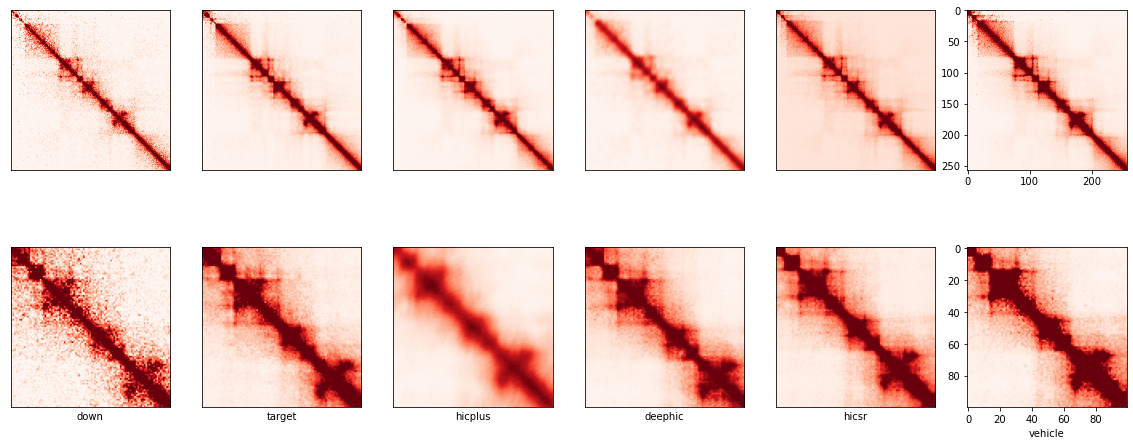

torch.Size([269, 269])
torch.Size([269, 269])
torch.Size([257, 257])
torch.Size([269, 269])
torch.Size([257, 257])
torch.Size([257, 257])
1/170
torch.Size([257, 257])


KeyboardInterrupt: 

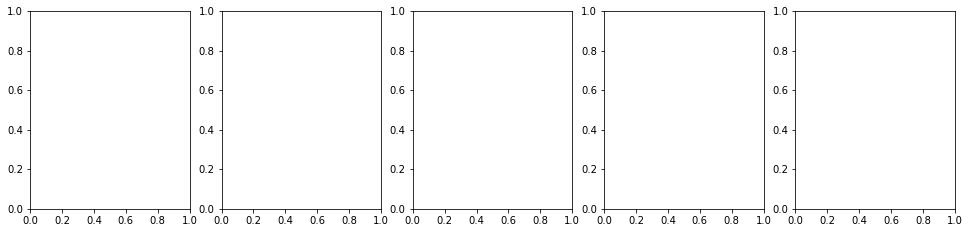

In [11]:
import torch
import pdb
import numpy as np
import matplotlib.pyplot as plt
from Data.GM12878_DataModule import GM12878Module

import models_to_compare.models.hicsr as hicsr
import models_to_compare.models.deephic as deephic
import models_to_compare.models.hicplus as hicplus
import VEHiCLE_Module as vehicle

chro = 14
dm_test = GM12878Module(batch_size=1,
                       res=10000,
                       piece_size=269)
dm_test.prepare_data()
dm_test.setup(stage=chro)

model_vehicle = vehicle.GAN_Model()
model_hicplus = hicplus.Net(269, 257)
model_hicsr   = hicsr.Generator(num_res_blocks=15)
model_deephic = deephic.Generator(scale_factor=1,
                                 in_channel=1,
                                 resblock_num=5)


#load weights
model_vehicle = model_vehicle.load_from_checkpoint("vehicle_weights.ckpt")
model_deephic.load_state_dict(torch.load("Expanded_Window_Models/big_269_generator_deephic.pytorch"))
model_hicplus.load_state_dict(torch.load("Expanded_Window_Models/big_269_hicplus.pytorch"))
model_hicsr.load_state_dict(torch.load("experiments/HiCSR_Big_269/HiCSR_Big_269.pth"))
for s, sample in enumerate(dm_test.test_dataloader()):
    print(str(s)+"/"+str(dm_test.test_dataloader().dataset.data.shape[0]))
    data, target, _ = sample
    downs           = data[0][0]
    target          = target[0][0]
    vehicle_out     = model_vehicle(data).detach()[0][0]
    hicplus_out     = model_hicplus(data).detach()[0][0]
    hicsr_out       = model_hicsr(data).detach()[0][0]
    deephic_out     = model_deephic(data).detach()[0][0]
    print(hicplus_out.shape)
    fig, ax = plt.subplots(2,6, figsize=(20,8))
    ax[0,0].imshow(downs, cmap="Reds")
    ax[0,1].imshow(target, cmap="Reds")
    ax[0,2].imshow(deephic_out, cmap="Reds")
    ax[0,3].imshow(hicplus_out, cmap="Reds")
    ax[0,4].imshow(hicsr_out, cmap="Reds")
    ax[0,5].imshow(vehicle_out, cmap="Reds")
    ax[1,0].imshow(downs[100:200,100:200], cmap="Reds")
    ax[1,1].imshow(target[100:200,100:200], cmap="Reds")
    ax[1,2].imshow(hicplus_out[100:200,100:200], cmap="Reds")
    ax[1,3].imshow(deephic_out[100:200,100:200], cmap="Reds")
    ax[1,4].imshow(hicsr_out[100:200,100:200], cmap="Reds")
    ax[1,5].imshow(vehicle_out[100:200,100:200], cmap="Reds")
    ax[1,0].set_xlabel("down")
    ax[1,1].set_xlabel("target")
    ax[1,2].set_xlabel("hicplus")
    ax[1,3].set_xlabel("deephic")
    ax[1,4].set_xlabel("hicsr")
    ax[1,5].set_xlabel("vehicle")
    for i in range(0,5):
        for j in range(0,2):
            ax[j,i].set_xticks([])
            ax[j,i].set_yticks([])
    plt.show()
    print(downs.shape)
    print(target.shape)
    print(hicplus_out.shape)
    print(deephic_out.shape)
    print(hicsr_out.shape)
    print(vehicle_out.shape)
    
#compute vision metrics
vm = {}
chro = 20
visionMetrics = vm.visionMetrics()
visionMetrics.setDataset(chro)
vm[chro, 'vehicle'] = visionMetrics.getMetrics(model=model_vehicle, splitter="vehicle")

